**Importing libraries and loading the data**

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pickle

In [3]:
#Load pre-counted dataframe
final_df = pd.read_csv('../data/interim/final_df.csv')
#final_df.date = pd.to_datetime(final_df.date)

In [4]:
final_df.dropna(axis = 0, subset=["sales_d_1", "sales_d_2", "sales_d_3",
               "sales_month_avg", "sales_week_avg"], inplace=True)

In [5]:
#Modeling - data preparation
final_df = final_df.sort_values(by='date')
final_df.d = final_df.d - final_df.d.min() + 1
final_df = final_df[['item_id',  'store_id',  #categorical - product definition, out because of high correlation - 'state_id', 'cat_id', 'id', 'dept_id',
                     'weekday', 'month', 'event_type', #categorical - time definition and event - sesonality
                     'd',  #trend - 'wm_yr_wk', 'year',
                     'sell_price','sales','turnover',
                     "sales_d_1", "sales_d_2", "sales_d_3",
                      "sales_month_avg","sales_week_avg"]] # ,"sales_week_avg"

In [6]:
#Make dummy variables (one-hot encoding)
#final_df = pd.get_dummies(final_df, columns=['id','item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','weekday', 'month', 'event_type'], drop_first=False)

final_df = pd.get_dummies(final_df, columns=['item_id', 'store_id', 'weekday', 'month', 'event_type'], drop_first=False)

In [7]:
final_df = final_df.drop(columns=['item_id_HOBBIES_1_049', 'store_id_CA_1', 'weekday_Monday', 'month_January'])

In [8]:
#Dataframe to train+validation and test data
X = final_df.drop(columns=['sales'])
y = final_df.sales
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [9]:
turnover_train = X_train.turnover
turnover_test = X_test.turnover

X_train = X_train.drop(columns=['turnover'])
X_test = X_test.drop(columns=['turnover'])

## Modeling

### Baseline model

In [10]:
#Baseline model based on only zeros
y_pred = pd.Series(np.zeros(len(y_test)))
rmse_baseline_sales = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE of baseline model for sales is {rmse_baseline_sales}")

rmse_baseline_turnover = np.sqrt(mean_squared_error(turnover_test, y_pred))
print(f"RMSE of baseline model for turnover is {rmse_baseline_turnover}")

RMSE of baseline model for sales is 1.4402969704813904
RMSE of baseline model for turnover is 7.540213610627589


In [11]:
#Baseline model based on average monthly value
y_pred = X_test.sales_month_avg
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE of better baseline model is {rmse_baseline}")

rmse_baseline_turnover = np.sqrt(mean_squared_error(turnover_test, y_pred*X_test.sell_price))
print(f"RMSE of baseline model for turnover is {rmse_baseline_turnover}")

RMSE of better baseline model is 1.07639247619992
RMSE of baseline model for turnover is 5.342454237117144


### Random Forest Regression

In [15]:
#Random Forest model
SEED = 88
param_grid = {
    'n_estimators': [2,5,10,15],
    'max_depth': [5,10,15,20], 
    'min_samples_split': [2,4,8], 
    'min_samples_leaf': [2,4,6],
    'max_features': ['sqrt', None , 'log2'] 
}

best_RMSE_sales = 999
best_RMSE_turnover = 999

best_params_sales = {}
best_params_turnover = {}

for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                for max_features in param_grid['max_features']:
                    # Create and train a Random Forest model with the current hyperparameters
                    rf = RandomForestRegressor(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        max_features=max_features,
                        random_state=SEED                        
                    )
                    rf.fit(X_train, y_train)

                    # Evaluate the model on the validation set
                    y_pred_rf = rf.predict(X_test)
                    RMSE_sales = np.sqrt(mean_squared_error(y_test, y_pred_rf))


                    # Update the best hyperparameters if this combination is better
                        # Update the best hyperparameters if this combination is better
                    if RMSE_sales < best_RMSE_sales:
                        best_RMSE_sales = RMSE_sales
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf,
                            'max_features': max_features
                        }
                    
                    RMSE_turnover = np.sqrt(mean_squared_error(turnover_test, y_pred_rf*X_test.sell_price)) 

                    if RMSE_turnover < best_RMSE_turnover:
                        best_RMSE_turnover = RMSE_turnover
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf,
                            'max_features': max_features
                        }
                    
                    print(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, '=> RMSE_sales: ', RMSE_sales, 'RMSE_turnover: ', RMSE_turnover)

2 5 2 2 sqrt => RMSE_sales:  1.152850395172215 RMSE_turnover:  5.921916514177445
2 5 2 2 None => RMSE_sales:  1.0698233789261196 RMSE_turnover:  5.381066424117765
2 5 2 2 log2 => RMSE_sales:  1.1833864840344464 RMSE_turnover:  5.974186393116964
2 5 2 4 sqrt => RMSE_sales:  1.152846726774837 RMSE_turnover:  5.921895387345085
2 5 2 4 None => RMSE_sales:  1.0694737605864666 RMSE_turnover:  5.381062844557569
2 5 2 4 log2 => RMSE_sales:  1.183386536825348 RMSE_turnover:  5.974186485979267
2 5 2 6 sqrt => RMSE_sales:  1.145788116148583 RMSE_turnover:  5.916613135444068
2 5 2 6 None => RMSE_sales:  1.0688906509030576 RMSE_turnover:  5.380703843637665
2 5 2 6 log2 => RMSE_sales:  1.183386536825348 RMSE_turnover:  5.974186485979267
2 5 4 2 sqrt => RMSE_sales:  1.152850395172215 RMSE_turnover:  5.921916514177445
2 5 4 2 None => RMSE_sales:  1.0698233789261196 RMSE_turnover:  5.381066424117765
2 5 4 2 log2 => RMSE_sales:  1.1833864840344464 RMSE_turnover:  5.974186393116964
2 5 4 4 sqrt => RMSE_s

In [31]:
print('Best parameters for sale prediction: ',best_params_sales)
print('Best parameters for turnover prediction: ',best_params_turnover)

print('Best RMSE for sales prediction: ',best_RMSE_sales) #15 10 8 6 None, 15 10 4 6 None , 15 10 2 6 None 
print('Best RMSE for turnover prediction: ',best_RMSE_turnover) #15 20 2 2 sqrt, 15 20 4 2 sqrt

Best parameters for sale prediction:  {'n_estimators': 15, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': None}
Best parameters for turnover prediction:  {'n_estimators': 15, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best RMSE for sales prediction:  1.0552336607356605
Best RMSE for turnover prediction:  5.322859696665507


In [23]:
SEED = 88

random_state=SEED 
n_estimators=best_params_turnover['n_estimators']
max_depth=best_params_turnover['max_depth']
min_samples_split=best_params_turnover['min_samples_split']
min_samples_leaf=best_params_turnover['min_samples_leaf']
max_features=best_params_turnover['max_features']                     

rf = RandomForestRegressor(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        max_features=max_features,
                        random_state=SEED                        
                    )
rf.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_rf = rf.predict(X_test)

RMSE_turnover = np.sqrt(mean_squared_error(turnover_test, y_pred_rf*X_test.sell_price)) 
print(RMSE_turnover)

5.322859696665507


In [28]:
pd.DataFrame({'Variable':X_train.columns,
              'Importance':rf.feature_importances_}).sort_values('Importance', ascending=False).head(50)

,Variable,Importance
5,sales_month_avg,0.311134
6,sales_week_avg,0.166083
2,sales_d_1,0.100489
4,sales_d_3,0.087991
3,sales_d_2,0.086614
0,d,0.038902
1,sell_price,0.024033
21,item_id_FOODS_2_256,0.010037
77,store_id_CA_3,0.009800
86,weekday_Saturday,0.009294


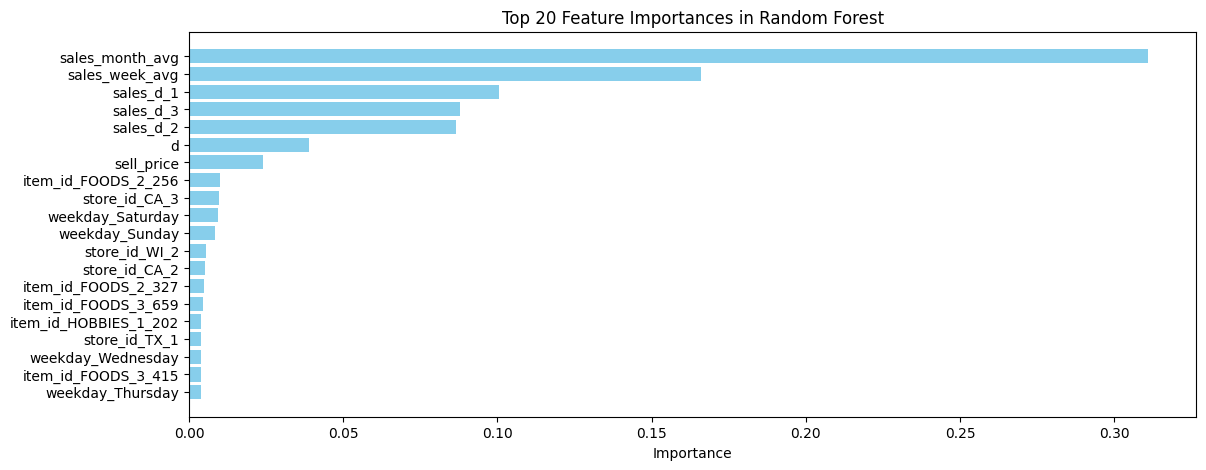

In [44]:
feature_importance_df = pd.DataFrame({'Variable': X_train.columns, 'Importance': rf.feature_importances_})

top_20_features = feature_importance_df.sort_values('Importance', ascending=True).tail(20)

plt.figure(figsize=(13, 5))
plt.barh(top_20_features['Variable'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances in Random Forest')
plt.show()

In [30]:
with open('../models/rndm_forest_model.pkl', 'wb') as file:
    pickle.dump(rf, file)